# Raspberry Pi Performance Investigation

Libraries to be used in the file parsing.

## Library imports

In [1]:
import os.path # Used for isfile()

# For plotting
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib

import numpy as np                      # for arange
from collections import OrderedDict     # For creation of a sorted dictionary
from itertools import zip_longest       # For zipping lists that are of uneven size

## Initial Helper Functions

The following function is used to parse through the files that do not have any particular program that I am interested in.

In [2]:
def parseTop(oldfile, newfile, wordsToDelete):
    """
    This function takes in a top file run in batch mode and removes the headers
    The remaining file should only be process information
    """
    if not os.path.isfile(newfile):
        with open(oldfile) as f, open(newfile, "w") as nf:
            for line in f:
                if not any(line.startswith(no) for no in wordsToDelete):    # removes any line that starts with a word in wordsToDelete
                    if not line.isspace():                                  # removes any empty lines
                        nf.write(line.lstrip(' '))                          # The lstrip method is to remove the starting empty space
    else:
        pass

Then I want to have a version of the above function that returns a new file that only has the process I'm interested in.

In [3]:
def returnOne(oldfile, newfile, processName):
    """
    Takes in an oldfile location and a new file location
    old file location is a top batch file
    new file is the oldfile where only one process
    """
    if not os.path.isfile(newfile):
        with open(oldfile) as f, open(newfile, "w") as nf:
            for line in f:
                if processName in line:
                    nf.write(line)

    else:
        pass

Then finally I want to read the new files that have been parsed and return a dictionary storing all the PIDs and the corresponding CPU usage and memory usage.

In [4]:
def readFile(file = "result.txt"):
    """
    This function takes in a file and returns lists of all processes as dictionaries
    The dictionaries have the structure of d = {'123': [1, 2, 3, 4, 5]}
    The key is Process ID number and always greater than 0 stored as string
    List contains floats
    """
    
    # PIDCPU will hold a key to a PID
    # number and output a list of CPU used
    # PIDMEM will do the very same
    # thing however with the MEM used

    PIDCPU = {}
    PIDMEM = {}
    if os.path.isfile(file):
        with open(file) as f:
            for line in f:
                if not line.startswith("PID"):
                    s = line.split()

                    # s[0] is the very first string in
                    # the line. This is always PID number

                    if s[0] not in PIDCPU or s[0] not in PIDMEM:
                        # s[8] is the %CPU number
                        PIDCPU[s[0]] = list()
                        PIDCPU[s[0]].append(float(s[8]))

                        # s[9] is the %MEM number
                        PIDMEM[s[0]] = list()
                        PIDMEM[s[0]].append(float(s[9]))
                    else:
                        PIDCPU[s[0]].append(float(s[8]))
                        PIDMEM[s[0]].append(float(s[9]))

            return PIDCPU, PIDMEM
    else:
        print("File does not exist")

## File Locations

The file locations are then put into variables along with some words to avoid

At some point, I will look into zipping all of these files and then this section will also have the unzipping of all the files. This will become important as I get more text files and also I still want to import the original PIPROGRAM file. At the moment, it is too large to be used with github.

In [5]:
# Every data point has 2 minutes in between
PI = "../Text/pi.txt"
PIRESULT = "../Results/Text/piResult.txt"

PIPROGRAM = "../Text/piProgram.txt"
PIPROGRESULT = "../Results/Text/piProgResult.txt"

avoid = ["top", "Tasks", "%Cpu(s)", "KiB Mem", "KiB Swap"]

Here I begin by parsing through the RPI files where no program was running.

Through some inspection of the files, I know that w1_bus_master (PID = 169) and docker (PID = 455, 499) seem to be the biggest CPU consumers.

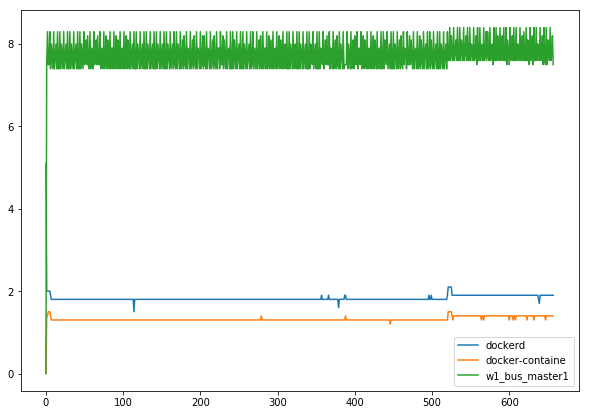

In [6]:
parseTop(PI, PIRESULT, avoid)
cpuPi, memPi = readFile(PIRESULT)

x = np.arange(0, len(cpuPi["455"]))

y1 = cpuPi["455"]
y2 = cpuPi["499"]
y3 = cpuPi["169"]

plt.figure(figsize=(10,7))
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

plt.legend(["dockerd", "docker-containe", "w1_bus_master1"], loc = "lower right")
plt.show()

For memory, the most consuming tasks are a little different. Docker consumes quite a bit of memory (PID = 455, 499) however the bus doesn't.

Through inspection, the sshd (PID = 448), bash (PID = 532), systemd (PID = 1), mtpd (PID = 475), vncserver (PID = 451) all consume >1% of %MEM.

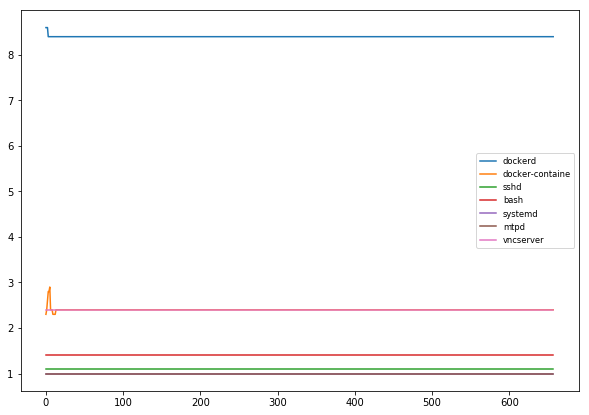

In [7]:
x = np.arange(0, len(memPi["455"]))

z1 = memPi["455"]
z2 = memPi["499"]
z3 = memPi["448"]
z4 = memPi["532"]
z5 = memPi["1"]
z6 = memPi["475"]
z7 = memPi["451"]

plt.figure(figsize=(10,7))
plt.plot(x, z1)
plt.plot(x, z2)
plt.plot(x, z3)
plt.plot(x, z4)
plt.plot(x, z5)
plt.plot(x, z6)
plt.plot(x, z7)

fontP = FontProperties()
fontP.set_size('small')

plt.legend(["dockerd", "docker-containe", "sshd", "bash", "systemd", "mtpd", "vncserver"],
          prop = fontP)
plt.show()

Now, it's time to see how much CPU/MEM the audio and fft take.

First, create the two dictionaries I will be graphing with

In [8]:
returnOne(PIPROGRAM, PIPROGRESULT, "main")
cpu, mem = readFile(PIPROGRESULT)

Then the creation of a simple line graph.

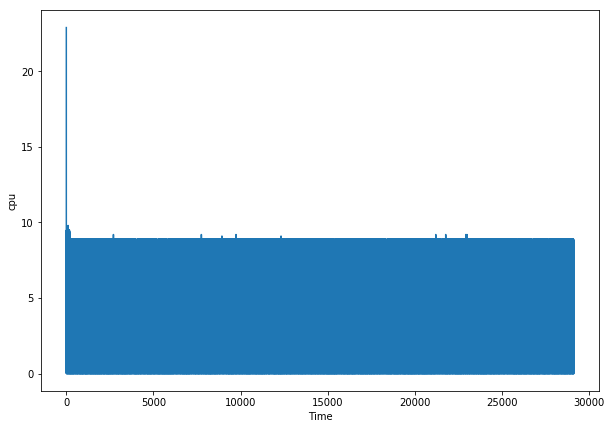

In [9]:
l = np.arange(0, len(cpu['21540']))
y = cpu['21540']

plt.figure(figsize=(10,7))
plt.plot(l, y)
plt.xlabel("Time")
plt.ylabel("cpu")
plt.show()

Unfortunately, when I was taking the results, I forgot to put in a reasonable delay. So, here I just graph only 100 results.

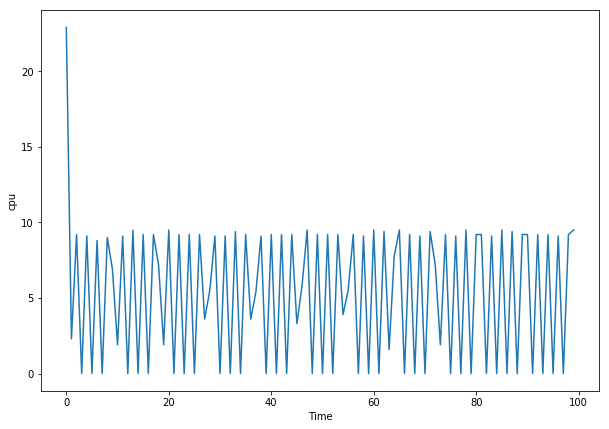

In [10]:
l1 = np.arange(0, len(cpu['21540'][0:100]))
f1 = cpu['21540'][0:100]

plt.figure(figsize=(10,7))
plt.plot(l1, f1)
plt.xlabel("Time")
plt.ylabel("cpu")
plt.show()

Now in terms of memory.

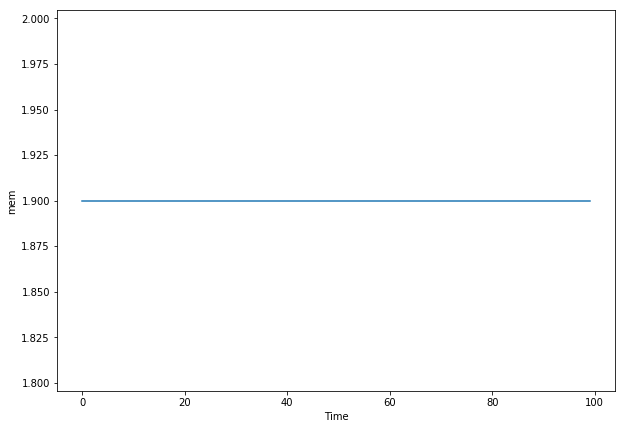

In [11]:
mx1 = np.arange(0, len(mem['21540'][0:100]))
my1 = mem['21540'][0:100]

plt.figure(figsize=(10,7))
plt.plot(mx1, my1)
plt.xlabel("Time")
plt.ylabel("mem")
plt.show()

## Deeper Look

### Raspberry Pi Idle Case

### CPU

From doing a more through inspection of the initial data, we can see that the there is something I missed initially.

Process 12328 consumes 11% of the cpu power on average. After that, only the 3 processes I mentioned consume any kind of real processor power. The rest is all sub 0.1% cpu. At a later stage, I will probably combine everyone of these cpu processes together.

Purely for finding some way of finding the CPU consumers, I decided to just rank them by average performance. Due to the nature of the data points, this isn't perfect as it is revealed that the highest average performer (PID = 12328) only ever has 2 values so it has a high performance of 11.25%. This means the choice of top 4 CPU hogs isn't perfect but it's somewhere to start.

In [12]:
def ave(d):
    '''
    This function takes in a dictionary {k : []}and returns an Ordered Dictionary
    The Ordered Dictionary has the same key as input dictionary
    Output is no longer a list but the mean of that list
    '''
    
    average = {}

    for k in d:
        mean = np.mean(d[k])
        average[k] = mean
        
    # Reverse has to be used here because the sorted function sorts from lowest to highest
    # Ultimately my use case doesn't care what order it is, but for printing it would be
    # nice to have highest to lowest
    return OrderedDict(sorted(average.items(), reverse = True, key = lambda t: t[1]))

sortedCPU = ave(cpuPi)

for k in sortedCPU:
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

Key: 12328	Mean 11.25
Key: 169	Mean 7.76823708207
Key: 455	Mean 1.82887537994
Key: 499	Mean 1.31975683891
Key: 553	Mean 0.1
Key: 118	Mean 0.0998480243161
Key: 451	Mean 0.0998480243161
Key: 9259	Mean 0.090625
Key: 11974	Mean 0.0894736842105
Key: 10938	Mean 0.0888888888889
Key: 336	Mean 0.0888888888889
Key: 2593	Mean 0.0875
Key: 7968	Mean 0.0875
Key: 31936	Mean 0.0866666666667
Key: 1016	Mean 0.0866666666667
Key: 3612	Mean 0.0866666666667
Key: 6335	Mean 0.0864864864865
Key: 10102	Mean 0.0846153846154
Key: 1652	Mean 0.0833333333333
Key: 3304	Mean 0.0833333333333
Key: 5093	Mean 0.0833333333333
Key: 628	Mean 0.0833333333333
Key: 2295	Mean 0.0833333333333
Key: 2090	Mean 0.0818181818182
Key: 7733	Mean 0.0818181818182
Key: 10557	Mean 0.08125
Key: 32431	Mean 0.08125
Key: 3905	Mean 0.08
Key: 4217	Mean 0.08
Key: 5375	Mean 0.0791666666667
Key: 1176	Mean 0.0785714285714
Key: 3579	Mean 0.0785714285714
Key: 7514	Mean 0.0777777777778
Key: 30313	Mean 0.0777777777778
Key: 30514	Mean 0.0777777777778
Key: 

The following function deinition is simply a helper function to transform the dictionaries I created at the start into a much more useful to graph version. The original version was inconvenient to graph as it had to many key, value pairs. This function should reduce the key, value pairs to only certain keys that I care about. The rest of the key, value pairs are then combined together as just being a 'rest of them' key with a value being the direct addition of their lists.

In [13]:
keys = ['12328', '169', '455', '499']


def prep_for_graph(d, keys):
    '''
    d = Dictionary that will be reduced to be only the keys specified with the rest combined
    returns a reduced dictionary that only contains much less key, value pairs
    '''
    concise = {}
    t = []

    for k in d:
        if k in keys:
            concise[k] = d[k]
        else: # At this point, I want to add everything into an 'everything else' list
            t = [x + y for x, y in zip_longest(t, d[k], fillvalue = 0)]

    concise['all'] = t
    
    # Find what the largest list in the dictionary is
    largest = 0
    for k in concise:
        if len(concise[k]) > largest:
            largest = len(concise[k])
            
    for k in concise:
        if len(concise[k]) < largest:
            concise[k].extend([0] * (largest - len(concise[k])))
    
    return concise

concise = prep_for_graph(cpuPi, keys)

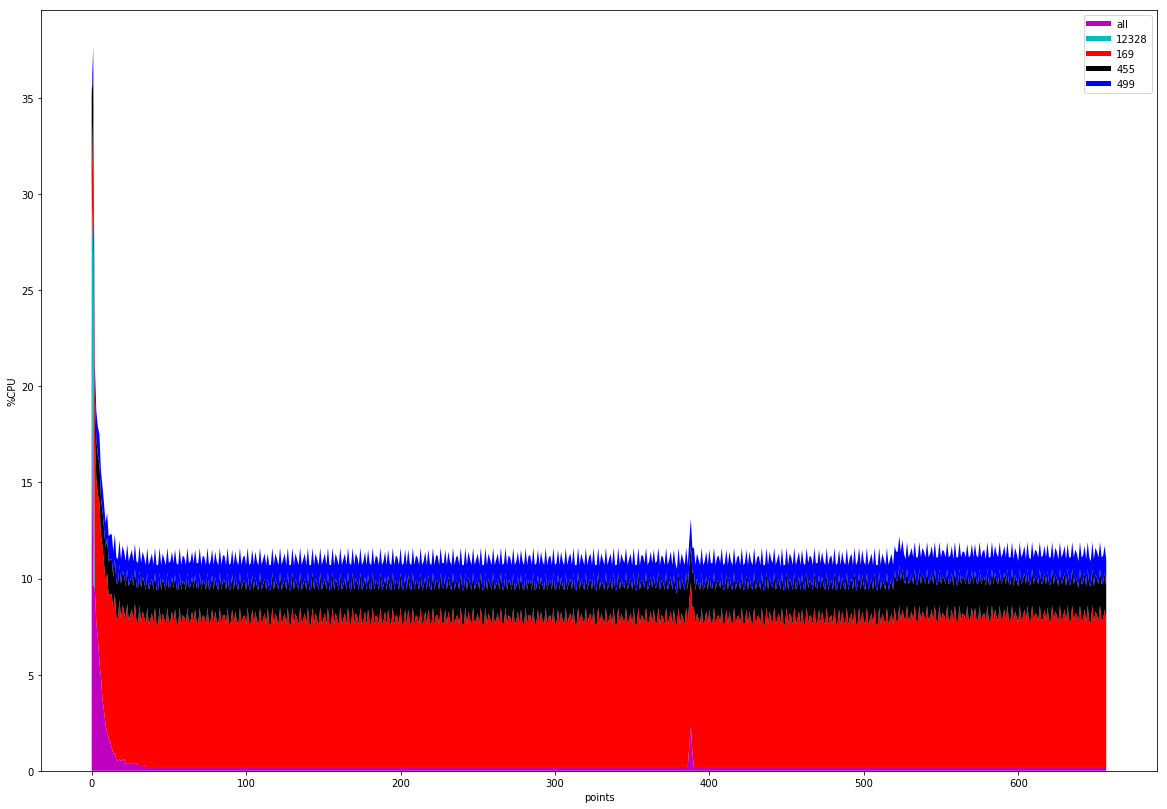

In [23]:
points = np.arange(0, len(concise['all']))
    
fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up

ax.plot([], [], color = 'm', label = 'all', linewidth = 5)
ax.plot([], [], color = 'c', label = '12328', linewidth = 5)
ax.plot([], [], color = 'r', label = '169', linewidth = 5)
ax.plot([], [], color = 'k', label = '455', linewidth = 5)
ax.plot([], [], color = 'b', label = '499', linewidth = 5)

ax.stackplot(points, concise['all'], concise['12328'], concise['169'],
             concise['455'], concise['499'], colors=['m','c','r','k', 'b'])

ax.set_ylabel('%CPU')
ax.set_xlabel('points')
ax.legend()
plt.show()